# Inputs

In [1]:
import os
import re

folder_name = '327/Pulse Calibration Redo'
file_names = [file_name for file_name in os.listdir(folder_name) if re.match(r'^\d+_\d+\.csv$', file_name)]

# Import packages

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
import numpy as np
import scipy.optimize as opt
from scipy.stats import t
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter1d
# %matplotlib widget

In [3]:
# Fit a decaying exponential to the envelope (no need for peak detection here)
# Model: A * exp(-t / T2*) + C
def model_exp(t, A, T2star, C):
    return A * np.exp(-t / T2star) + C

# Load data

In [5]:
# Read the data and pulse times from filenames
data = []
pulse_times = []
for file_name in file_names:
    # Assumes the file name format has the pulse time (in us) before 'us'
    pulse_time = int(file_name.split('/')[-1].split('_')[0])
    df = pd.read_csv(os.path.join(folder_name, file_name), header=None, names=['t', 'CH1', 'CH2'])
    df = df.dropna()
    df = df[(df['t'] > 0.001) & (df['t'] < 0.003)]
    data.append(df)
    pulse_times.append(pulse_time)

# Use sum of squares to reconstruct envelope, and fit envelope

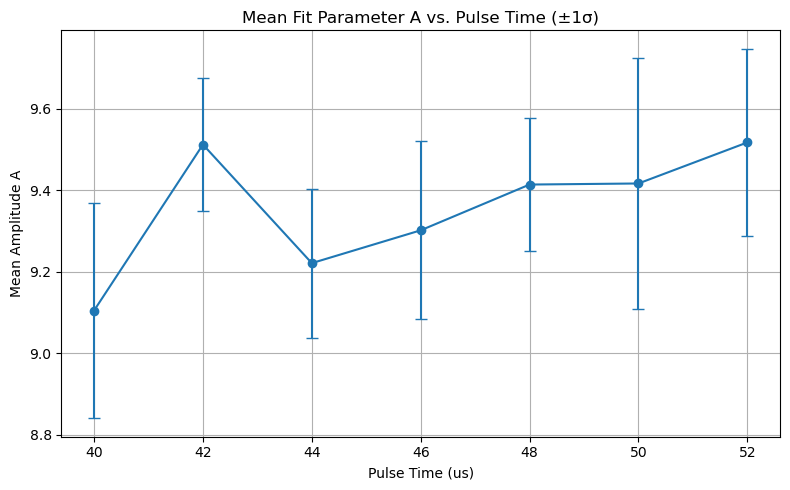

In [11]:
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Dictionary to store individual fit results per pulse time.
fit_results_by_pulse = defaultdict(list)

# Loop over each trace individually.
for df, pulse_time in zip(data, pulse_times):
    t = df['t'].values
    real = df['CH1'].values - df['CH1'].iloc[-1]
    imag = df['CH2'].values - df['CH2'].iloc[-1]
    mag = np.sqrt(real**2 + imag**2)
    
    # Sort the data by time for a cleaner fit.
    sort_idx = np.argsort(t)
    t_sorted = t[sort_idx]
    mag_sorted = mag[sort_idx]
    
    # Set up an initial guess for the parameters.
    # Here, p0 = [initial amplitude, decay time, baseline offset].
    p0 = [mag_sorted[0], (t_sorted.max() - t_sorted.min()) / 2, np.min(mag_sorted)]
    
    try:
        popt, pcov = curve_fit(model_exp, t_sorted, mag_sorted, p0=p0)
        perr = np.sqrt(np.diag(pcov))
    except RuntimeError:
        popt = [np.nan, np.nan, np.nan]
        perr = [np.nan, np.nan, np.nan]
    
    # Save the individual fit parameters and their errors.
    fit_results_by_pulse[pulse_time].append({
        'A': popt[0],
        'T2*': popt[1],
        'C': popt[2],
        'A_err': perr[0],
        'T2*_err': perr[1],
        'C_err': perr[2]
    })

# Now, average the fit parameters for each pulse time and calculate their standard deviations.
avg_fit_results = []
for pulse_time, results in sorted(fit_results_by_pulse.items()):
    # Extract lists of each parameter (ignoring NaN values).
    A_values = [r['A'] for r in results if not np.isnan(r['A'])]
    T2_values = [r['T2*'] for r in results if not np.isnan(r['T2*'])]
    C_values = [r['C'] for r in results if not np.isnan(r['C'])]
    
    # Compute the mean values.
    A_mean = np.mean(A_values)
    T2_mean = np.mean(T2_values)
    C_mean = np.mean(C_values)
    
    # Compute the sample standard deviation (with ddof=1 for an unbiased estimate)
    A_std = np.std(A_values, ddof=1) if len(A_values) > 1 else np.nan
    T2_std = np.std(T2_values, ddof=1) if len(T2_values) > 1 else np.nan
    C_std = np.std(C_values, ddof=1) if len(C_values) > 1 else np.nan
    
    avg_fit_results.append({
        'Pulse Time (us)': pulse_time,
        'A_mean': A_mean,
        'A_std': A_std,
        'T2*_mean (us)': T2_mean,
        'T2*_std (us)': T2_std,
        'C_mean': C_mean,
        'C_std': C_std
    })

results_df = pd.DataFrame(avg_fit_results).sort_values('Pulse Time (us)')

# Example plot: Mean A vs. Pulse Time with error bars from the sample standard deviation.
plt.figure(figsize=(8,5))
plt.errorbar(results_df['Pulse Time (us)'], results_df['A_mean'], 
             yerr=results_df['A_std'], fmt='o-', capsize=4)
plt.xlabel('Pulse Time (us)')
plt.ylabel('Mean Amplitude A')
plt.title('Mean Fit Parameter A vs. Pulse Time (±1σ)')
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/px/wy4h6r3d0pjcgpg5tm4lrp9h0000gn/T/ipykernel_38437/3545805551.py:13: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-t / T2) * np.exp(1j * (2 * np.pi * f * t + phi)) + (C_real + 1j * C_imag)


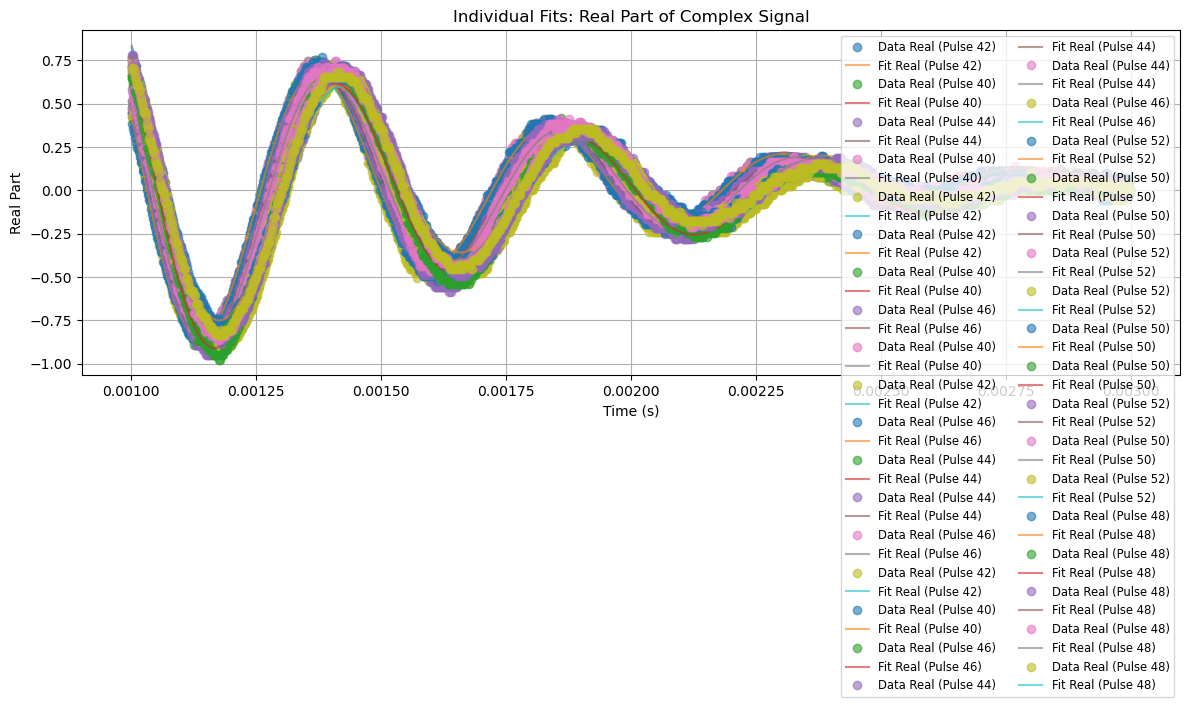

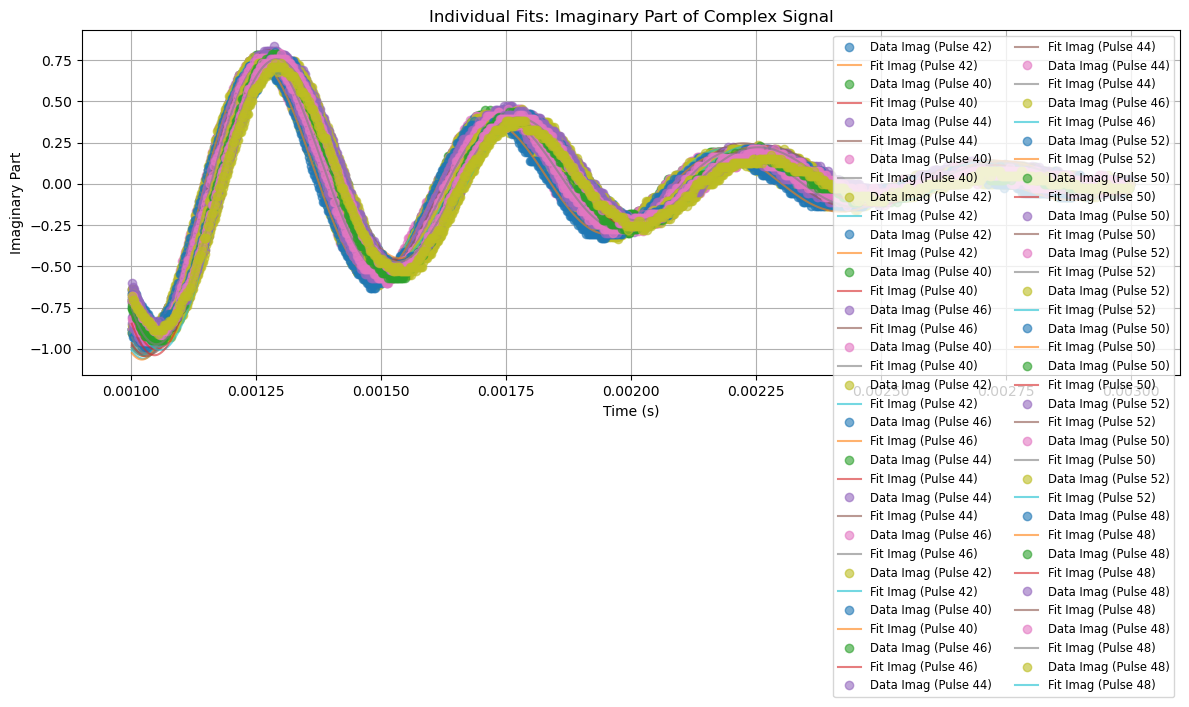

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.optimize import curve_fit

# Define the complex exponential model with frequency.
def model_complex(t, A, T2, f, phi, C_real, C_imag):
    """
    Returns the complex signal:
      A * exp(-t/T2) * exp(i*(2*pi*f*t + phi)) + (C_real + i*C_imag)
    """
    return A * np.exp(-t / T2) * np.exp(1j * (2 * np.pi * f * t + phi)) + (C_real + 1j * C_imag)

def model_complex_stacked(t, A, T2, f, phi, C_real, C_imag):
    """
    Returns a stacked 1D array of real and imaginary parts.
    This stacking is needed because curve_fit works with real-valued functions.
    """
    model_vals = model_complex(t, A, T2, f, phi, C_real, C_imag)
    return np.concatenate((model_vals.real, model_vals.imag))

# Dictionary to store fit results grouped by pulse time (if needed for averaging).
fit_results_by_pulse = defaultdict(list)
# List to store each individual trace's data and fit for plotting.
all_fits = []

# Loop over each individual trace.
for df, pulse_time in zip(data, pulse_times):
    # Cutoff after 0.003 s
    df = df[df['t'] < 0.003]
    
    # Get the time data.
    t = df['t'].values
    
    # Create the complex signal by subtracting the baseline (last point of each channel).
    baseline_real = df['CH1'].values[-1]
    baseline_imag = df['CH2'].values[-1]
    signal = (df['CH1'].values - baseline_real) + 1j * (df['CH2'].values - baseline_imag)

    # Normalize magnitude to 1 for better fitting.
    signal /= np.max(np.abs(signal))
    
    # Prepare the ydata by stacking the real and imaginary parts.
    ydata = np.concatenate((signal.real, signal.imag))
    
    # Initial guess for the parameters:
    # - A: amplitude from the first point's magnitude.
    # - T2: a guess (e.g., 0.001 s).
    # - f: initial guess for frequency (set to 1 Hz; change if needed).
    # - phi: phase from the first data point.
    # - C_real and C_imag: start with zero offset.
    p0 = [np.abs(signal[0]),
          0.001,
          2000,  # frequency initial guess (Hz)
          np.angle(signal[0]),
          0,
          0]
    
    try:
        popt, pcov = curve_fit(model_complex_stacked, t, ydata, p0=p0)
    except RuntimeError:
        popt = [np.nan] * 6
    
    # Evaluate the fitted model.
    fitted_curve = model_complex(t, *popt)
    
    # Save the individual fit results for later plotting.
    all_fits.append({
        'pulse_time': pulse_time,
        't': t,
        'data_real': signal.real,
        'data_imag': signal.imag,
        'fit_real': fitted_curve.real,
        'fit_imag': fitted_curve.imag
    })
    
    # Also store parameters for grouped analysis if needed.
    fit_results_by_pulse[pulse_time].append({
        'A': popt[0],
        'T2*': popt[1],
        'f': popt[2],
        'phi': popt[3],
        'C_real': popt[4],
        'C_imag': popt[5],
    })

# Plot individual fits for the real part.
plt.figure(figsize=(12, 6))
for fit in all_fits:
    plt.plot(fit['t'], fit['data_real'], 'o', alpha=0.6, label=f'Data Real (Pulse {fit["pulse_time"]})')
    plt.plot(fit['t'], fit['fit_real'], '-', alpha=0.6, label=f'Fit Real (Pulse {fit["pulse_time"]})')
plt.xlabel('Time (s)')
plt.ylabel('Real Part')
plt.title('Individual Fits: Real Part of Complex Signal')
plt.legend(fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot individual fits for the imaginary part.
plt.figure(figsize=(12, 6))
for fit in all_fits:
    plt.plot(fit['t'], fit['data_imag'], 'o', alpha=0.6, label=f'Data Imag (Pulse {fit["pulse_time"]})')
    plt.plot(fit['t'], fit['fit_imag'], '-', alpha=0.6, label=f'Fit Imag (Pulse {fit["pulse_time"]})')
plt.xlabel('Time (s)')
plt.ylabel('Imaginary Part')
plt.title('Individual Fits: Imaginary Part of Complex Signal')
plt.legend(fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()


# Use Hilbert transform to reconstruct envelope, then fit to decaying exponential (NOTE: doesn't work well)

In [68]:
PAD_SIZE = 1000
def fit_decay_with_envelope(df, channel='CH1', prominence=0.2, min_distance=100):
    t = df['t'].values
    signal_raw = df[channel].values
    
    # Compute the analytic signal using the Hilbert transform
    signal_padded = np.pad(signal_raw, (PAD_SIZE, PAD_SIZE), mode="reflect")
    signal_padded = gaussian_filter1d(signal_padded, sigma=10)  # Smoothing to suppress small oscillations
    analytic_signal_padded = hilbert(signal_padded)
    analytic_signal = analytic_signal_padded[PAD_SIZE:-PAD_SIZE]  # Remove padding
    envelope = np.abs(analytic_signal)  # Extract the envelope (magnitude of analytic signal)
    envelope = gaussian_filter1d(envelope, sigma=10)  # Smoothing to suppress small oscillations
    
    # Initial guess for parameters A, T2*, and C (use the first value of the envelope as A, and its decay time)
    p0 = [envelope[0], (t.max() - t.min()) / 2.0, np.min(envelope)]
    popt, _ = curve_fit(model_exp, t, envelope, p0=p0)

    return popt, envelope

In [ ]:
results = []
fits = []

TIME_CUTOFF = 0.003  # 3 ms cutoff for the time axis

# Loop through each dataset
for idx, (df, pulse_time) in enumerate(zip(data, pulse_times)):
    df = df[df['t'] < TIME_CUTOFF]  # Apply time cutoff

    t = df['t'].values
    real_signal = df['CH1'].values
    imag_signal = df['CH2'].values

    # Subtract linear fit
    real_signal -= np.polyval(np.polyfit(t, real_signal, 1), t)
    imag_signal -= np.polyval(np.polyfit(t, imag_signal, 1), t)

    # Apply the robust envelope fitting to both real and imaginary channels
    popt_real, env_real = fit_decay_with_envelope(df, channel='CH1')
    popt_imag, env_imag = fit_decay_with_envelope(df, channel='CH2')
    
    # Store results (e.g., the T2* from the exponential fit)
    results.append({
        'Dataset': idx + 1,
        'Pulse Time (us)': pulse_time,
        'Real_T2star': popt_real[1],
        'Imag_T2star': popt_imag[1]
    })

    fits.append((t, real_signal, imag_signal, env_real, env_imag, popt_real, popt_imag))

# Display summary results
results_df = pd.DataFrame(results)
print(results_df)

# ------------------
# PLOTTING THE FITS FOR EACH DATASET
# ------------------
# Plot the results
for idx, (t, real_signal, imag_signal, env_real, env_imag, popt_real, popt_imag) in enumerate(fits):
    # Plot Real Channel (CH1)
    plt.figure(figsize=(12, 5))

    # Real part
    plt.subplot(1, 2, 1)
    plt.plot(t, real_signal, 'k.', label='Data (real)')
    plt.plot(t, env_real, 'orange', label='Envelope (real)')
    plt.plot(t, model_exp(t, *popt_real), 'b--', label='Exp Fit (real)')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title(f'Dataset {idx+1} - Real')
    plt.legend()

    # Imaginary part
    plt.subplot(1, 2, 2)
    plt.plot(t, imag_signal, 'k.', label='Data (imag)')
    plt.plot(t, env_imag, 'orange', label='Envelope (imag)')
    plt.plot(t, model_exp(t, *popt_imag), 'b--', label='Exp Fit (imag)')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title(f'Dataset {idx+1} - Imaginary')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Display summary statistics for T2* (Real and Imaginary)
def summarize(series, label):
    mean = series.mean()
    std = series.std()
    sem = std / np.sqrt(len(series))
    ci95 = 1.96 * sem
    print(f"{label}:\n  Mean T2* = {mean:.4f} us\n  Std = {std:.4f}\n  SEM = {sem:.4f}\n  95% CI = ±{ci95:.4f}\n")

# Summary for Real (CH1) and Imaginary (CH2) T2* values
real_t2star = pd.Series([popt_real[1] for _, _, _, _, _, popt_real, _ in fits])
imag_t2star = pd.Series([popt_imag[1] for _, _, _, _, _, _, popt_imag in fits])

summarize(real_t2star, "Real T2*")
summarize(imag_t2star, "Imaginary T2*")

# ------------------
# PLOTTING THE 'A' FIT PARAMETER VS. PULSE TIME
# ------------------
# Here we use the 'A' parameter from the real-part fit as the scale.
pulse_A = [popt_real[0] for (_, _, _, _, _, popt_real, _) in fits]
df_A = pd.DataFrame({'Pulse Time (us)': pulse_times, 'A': pulse_A})
grouped_A = df_A.groupby('Pulse Time (us)')['A'].agg(['mean', 'std']).reset_index()

plt.figure(figsize=(8, 6))
plt.errorbar(grouped_A['Pulse Time (us)'], grouped_A['mean'], yerr=grouped_A['std'],
             fmt='bo-', capsize=5, label="Average A (±1 STD)")
plt.xlabel('Pulse Time (us)')
plt.ylabel('Fit Parameter A')
plt.title("Fit Parameter 'A' vs. Pulse Time")
plt.legend()
plt.show()